In [1]:
#导包
import pandas as pd
import numpy as np
#
import matplotlib.pyplot as plt
%matplotlib inline
#支持中文
import matplotlib as mpl
from matplotlib.font_manager import _rebuild
_rebuild()
mpl.rcParams["font.sans-serif"] = [u"SimHei"]
mpl.rcParams["axes.unicode_minus"] = False

from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz
import re
def add_datepart(df, fldname, drop=True, time=False):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [2]:
#设置图大小
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#归一化数据函数
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
#read the file
df = pd.read_csv('maotai2015.csv')
df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
926,2019-07-22,964.000000,950.250000,960.000000,957.020020,2812549.0,957.020020
927,2019-07-23,962.590027,943.859985,962.299988,953.979980,3248395.0,953.979980
928,2019-07-24,959.900024,944.690002,958.309998,946.359985,4677120.0,946.359985
929,2019-07-25,963.359985,938.150024,945.969971,963.000000,3825570.0,963.000000
930,2019-07-26,971.000000,958.549988,961.969971,965.030029,2646759.0,965.030029


In [3]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

plt.figure(figsize=(16,8),dpi=1000)
plt.plot(df['Close'], label='历史闭盘价格',linewidth=2,)
plt.grid(color="b", linestyle="-.",axis='y')
plt.legend()

E:\Anaconda\envs\tf\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [4]:
#线性回归
#将索引设置为日期
#df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
#df.index = df['Date']
#按日期排序
data = df.sort_index(ascending=True, axis=0)
#取出数据
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #过去的时间点

In [5]:
#划分训练集与验证集
#train = new_data[:4200]
#valid = new_data[4200:]
train = new_data[:650]
valid = new_data[650:]

In [6]:
x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

#线性回归
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)   #是不能得到得分的

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7]:
# 做出预测   ，并算损失
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

153.76552087802813

E:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
E:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


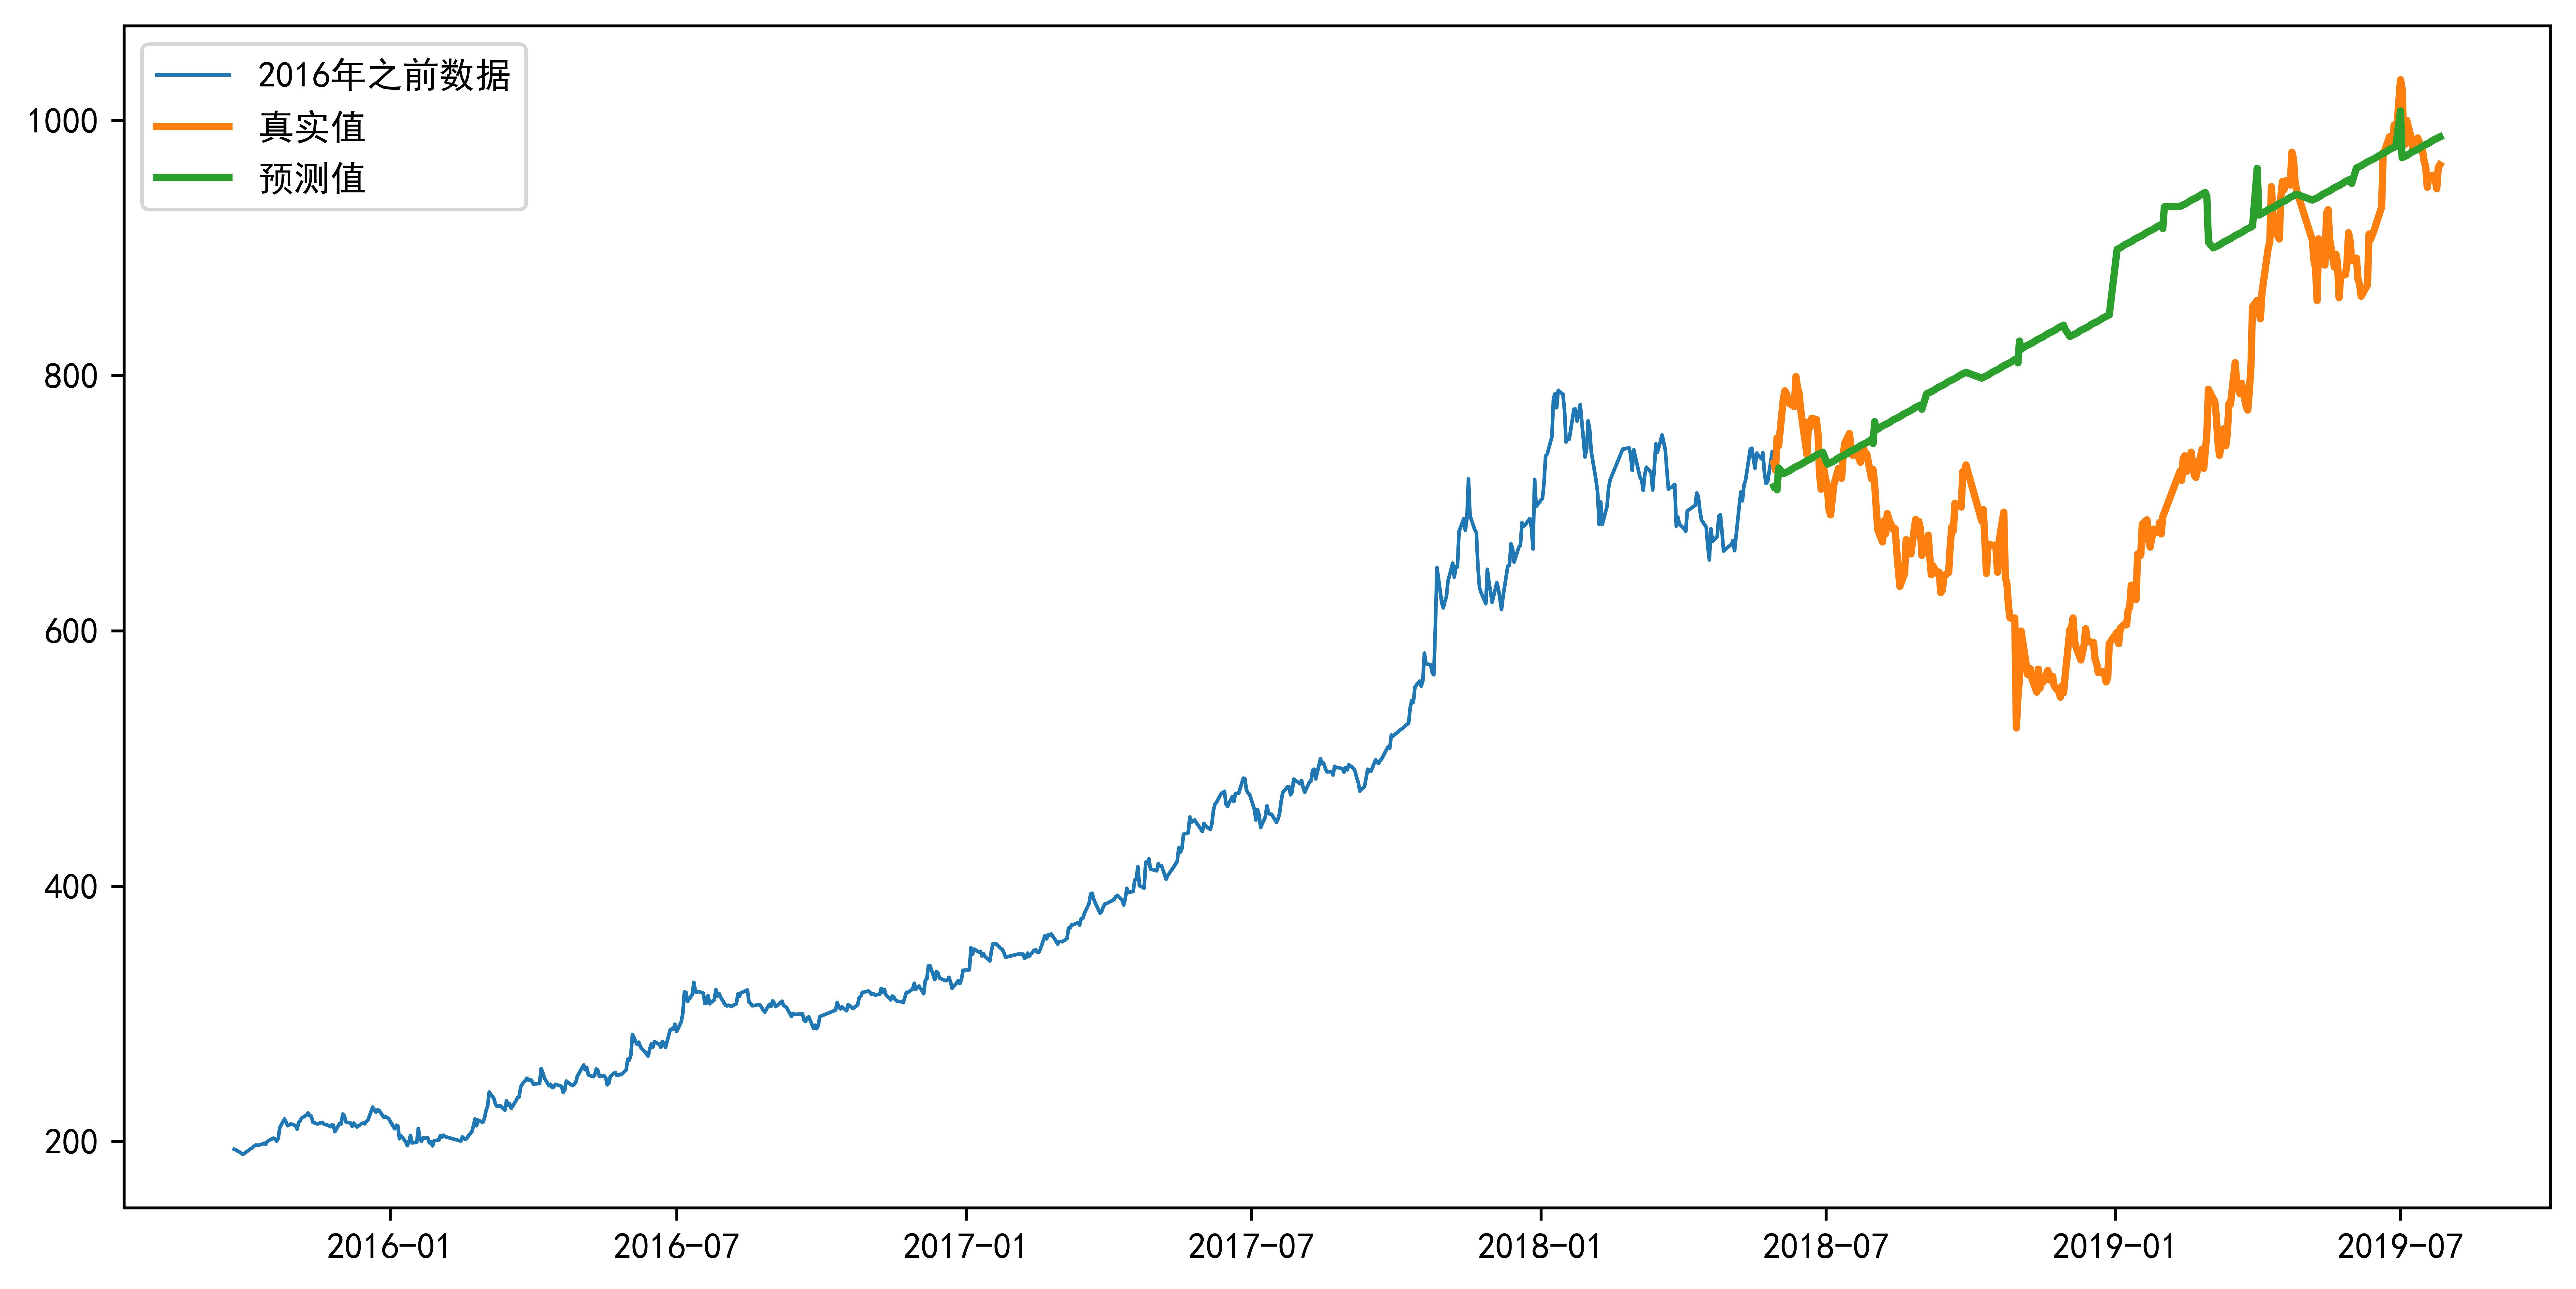

In [8]:
#plot
plt.figure(figsize=(12,6),dpi=800)
valid['Predictions'] = 0
valid['Predictions'] = preds
#valid.index = new_data[4200:].index
#train.index = new_data[:4200].index
valid.index = df[650:].index
train.index = df[:650].index
plt.plot(train['Close'],linewidth=1,label="2016年之前数据")
plt.plot(valid['Close'],linewidth=2,label="真实值")
plt.plot(valid['Predictions'],linewidth=2,label="预测值")
plt.legend()

In [9]:
#k-近邻

In [10]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [11]:
#标准化
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#使用gridsearch查找最佳参数
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#训练模型，并预测
model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [12]:
#损失
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

341.84439124497044

E:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
E:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


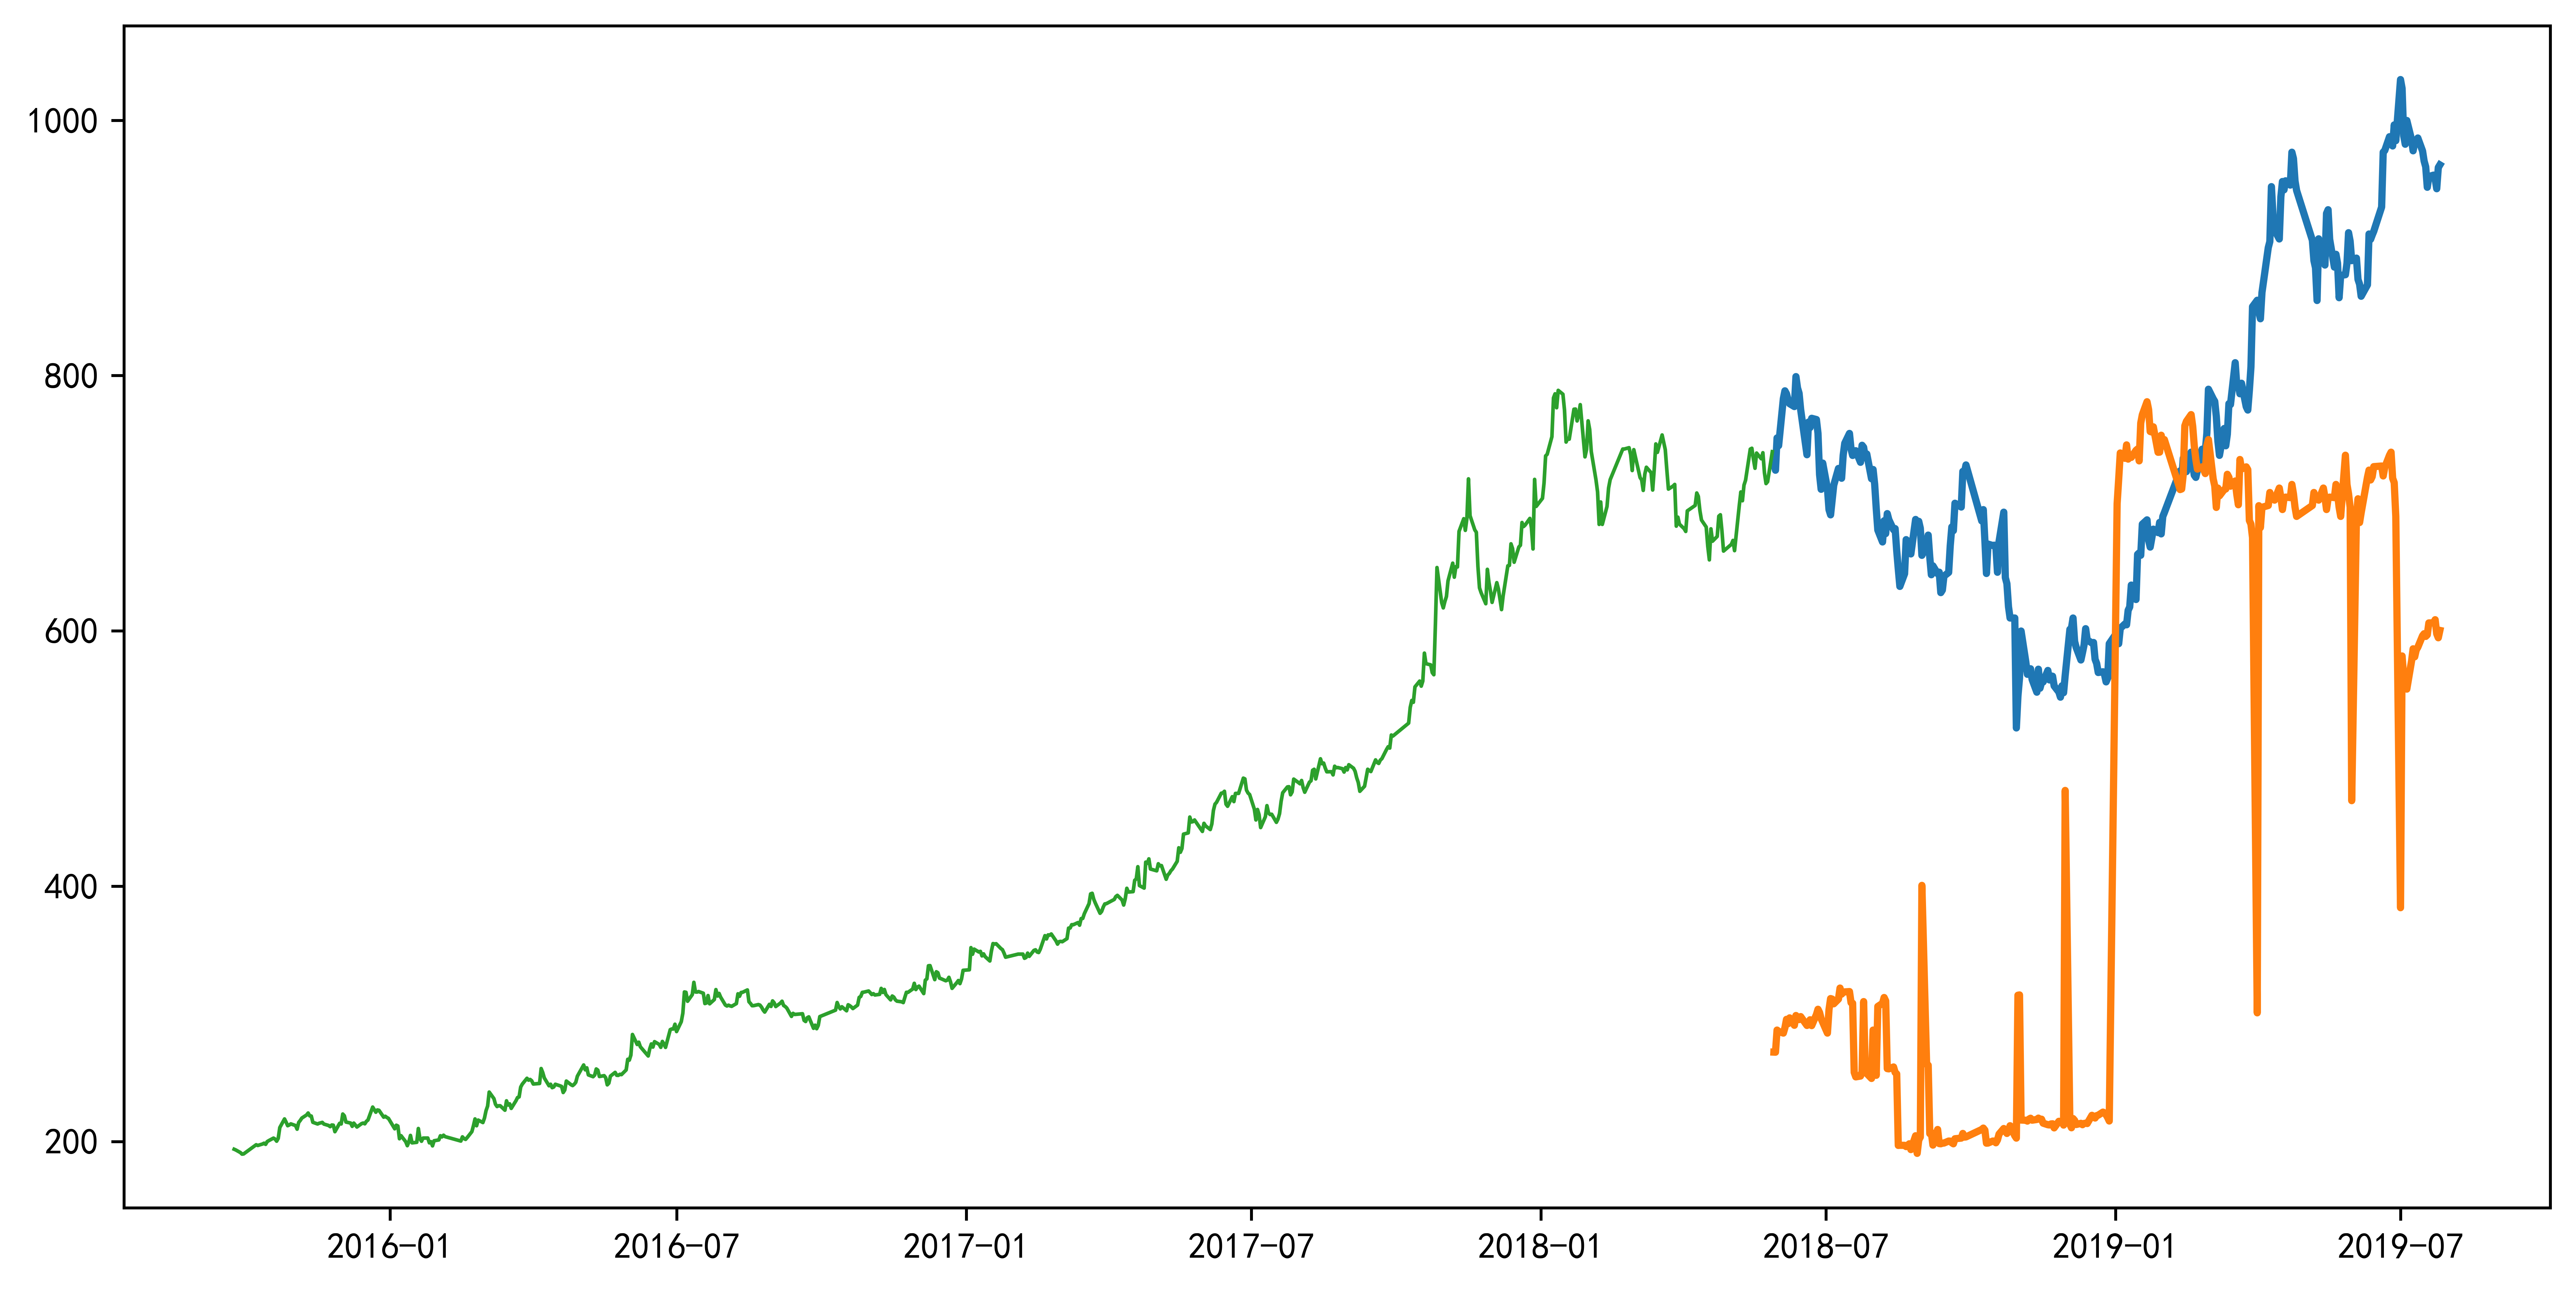

In [13]:
#plot
plt.figure(figsize=(12,6),dpi=800)
valid['Predictions'] = 0
valid['Predictions'] = preds
valid.index = df[650:].index
train.index = df[:650].index
plt.plot(valid['Close'],linewidth=2,label="真实值")
plt.plot(valid['Predictions'],linewidth=2,label="预测值")
plt.plot(train['Close'],linewidth=1,label="2016年之前数据")

In [14]:
#长短期记忆网络(LSTM)

In [15]:
#导包
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

 

#创建Dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#索引
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#创建训练集与测试集
dataset = new_data.values
#train = dataset[0:4200,:]
#valid = dataset[4200:,:]
train = dataset[0:650,:]
valid = dataset[650:,:]

 

#数据转换为 x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

 

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

 

# 创建LSTM网络
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#过去60来预测246
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

X_test = np.array(X_test)

 
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 141s - loss: 0.0042


In [16]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

40.36125011698257

E:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


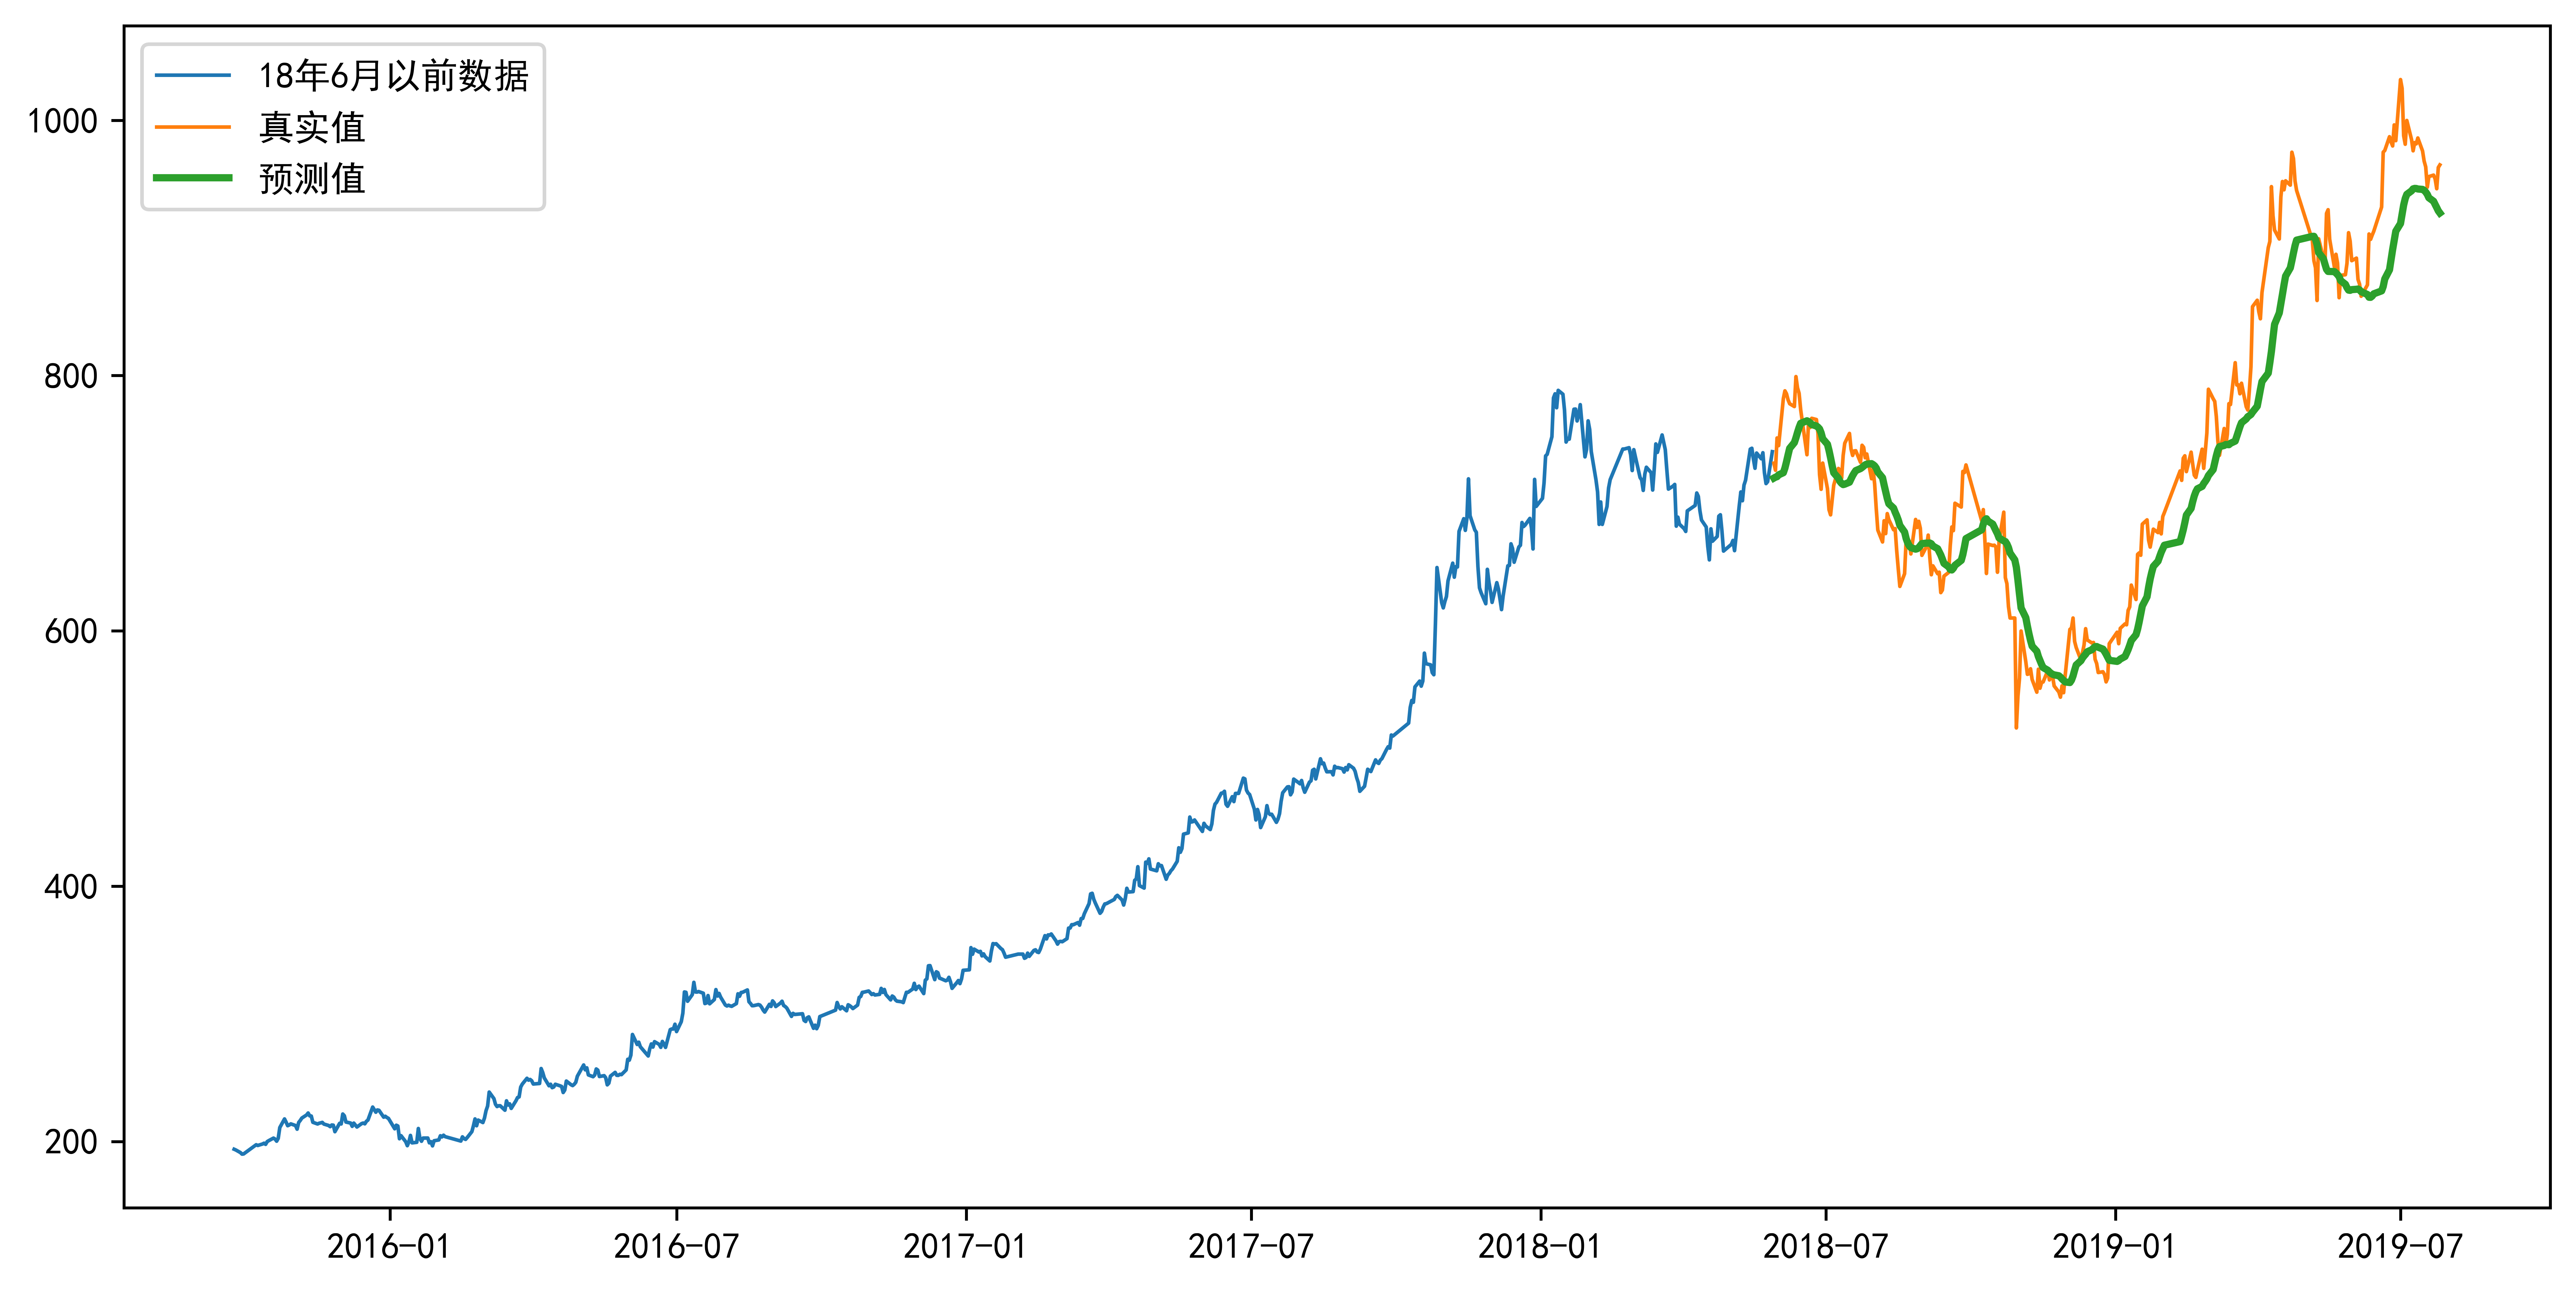

In [17]:
#
plt.figure(figsize=(12,6),dpi=800)
#train = new_data[:4200]
#valid = new_data[4200:]
train = new_data[:650]
valid = new_data[650:]
valid['Predictions'] = closing_price
plt.plot(train['Close'],linewidth=1,label="18年6月以前数据")
plt.plot(valid['Close'],linewidth=1,label="真实值")
plt.plot(valid['Predictions'],linewidth=2,label="预测值")
plt.legend()